In [256]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from imutils import paths
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 

In [257]:
def adjust_gamma(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [258]:
from skimage import feature
import numpy as np

#‘default’: original local binary pattern which is gray scale but not rotation invariant.
#‘ror’: extension of default implementation which is gray scale and rotation invariant.
#‘uniform’: improved rotation invariance with uniform patterns and finer quantization of the angular space which is gray scale and rotation invariant.
#‘nri_uniform’: non rotation-invariant uniform patterns variant which is only gray scale invariant.
#‘var’: rotation invariant variance measures of the contrast of local image texture which is rotation but not gray scale invariant.

class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius
        
    def lbp(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
        return lbp

    def describe(self, image, eps=1e-7):

        lbp = feature.local_binary_pattern(image, self.numPoints,self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))

        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        # return the histogram of Local Binary Patterns
        return hist

In [259]:
imagePaths = paths.list_images("E:/Pemrograman/Image Video Processing/Neural Network/3scene")
data = []
labels = []

desc = LocalBinaryPatterns(8, 1)
for imagePath in imagePaths:
    image = Image.open(imagePath)
    image = np.array(image.resize((224, 224))) / 255.0
    blur = cv2.GaussianBlur(image,None, 3)  
#     gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    lbp = desc.describe(gray)
    newaxis = lbp[np.newaxis, :]
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [260]:
print(labels)

['coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 

In [261]:
# encode the labels, converting them from strings to integers
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(labels)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [262]:
(trainX, testX, trainY, testY) = train_test_split(np.array(data),	np.array(labels), test_size=0.20)
print(trainX.shape)
print(testX.shape)

(758, 224, 224, 3)
(190, 224, 224, 3)


In [263]:
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization

In [264]:
from keras.layers import Dropout
base_model = MobileNet(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
out = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)  

In [265]:
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   mode='auto',
                   restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weight_scene_mobileNet.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',)

In [266]:
# from keras.models import Sequential
# from keras.layers.core import Flatten
# from keras.layers.core import Dense

# model = Sequential(
#     [
#         Flatten(input_shape=(64*64*3,)),
#         Dense(100, activation="relu", name="layer1"),
#         Dense(16, activation="relu", name="layer2"),
#         Dense(16, activation="relu", name="layer3"),
#         Dense(3, activation = "softmax", name="layer4"),
#     ]
# )

In [267]:
# model.summary()

In [268]:
# train the model using the Adam optimizer
print("[INFO] training network...")
opt = Adam(lr=1e-3, decay=1e-3 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=5, batch_size=32, callbacks=[es, checkpoint])

[INFO] training network...
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9340
Epoch 00001: val_accuracy improved from -inf to 0.57895, saving model to best_weight_scene_mobileNet.h5
24/24 [==============================] - 116s 5s/step - loss: 0.1640 - accuracy: 0.9340 - val_loss: 9.0941 - val_accuracy: 0.5789
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.9776
Epoch 00002: val_accuracy improved from 0.57895 to 0.77895, saving model to best_weight_scene_mobileNet.h5
24/24 [==============================] - 128s 5s/step - loss: 0.0731 - accuracy: 0.9776 - val_loss: 3.4185 - val_accuracy: 0.7789
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9749
Epoch 00003: val_accuracy did not improve from 0.77895
24/24 [==============================] - 127s 5s/step - loss: 0.1009 - accuracy: 0.9749 - val_loss: 3.7067 - val_accuracy: 0.7368
Epoch 4/5
24/24 [=====================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


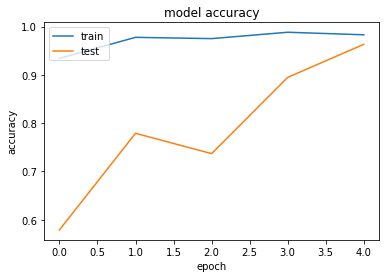

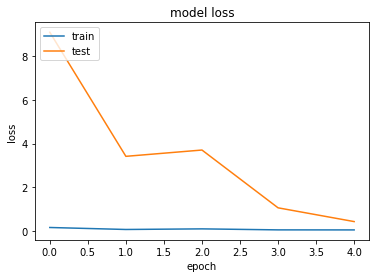

In [269]:
import matplotlib.pyplot as plt

print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [289]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       coast       0.91      1.00      0.95        72
      forest       1.00      0.96      0.98        69
     highway       1.00      0.92      0.96        49

    accuracy                           0.96       190
   macro avg       0.97      0.96      0.96       190
weighted avg       0.97      0.96      0.96       190



In [290]:
model.save('nnmodel_scene')

INFO:tensorflow:Assets written to: nnmodel_scene\assets


In [319]:
import cv2
image1='E:/Pemrograman/Image Video Processing/Neural Network/3scene/forest/forest_cdmc281.jpg'

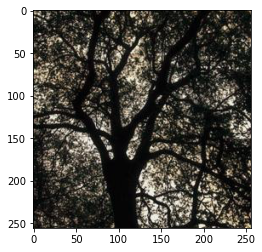

In [320]:
img_array = cv2.imread(image1)
plt.imshow(img_array)
plt.show()
# print(type(img_array))

In [321]:
image_testing = Image.open('E:/Pemrograman/Image Video Processing/Neural Network/3scene/forest/forest_cdmc281.jpg')
image_testing = np.array(image_testing.resize((224, 224))) / 255.0
image_testing.shape

(224, 224, 3)

In [322]:
image_testing = np.expand_dims(image_testing, axis=0)
print(image_testing.shape)

(1, 224, 224, 3)


In [323]:
output = model.predict(image_testing, 1)
print(output)
print(lb.classes_[output.argmax(axis=1)])

[[5.762166e-09 1.000000e+00 5.115665e-18]]
['forest']
